- Max Heading Difference between two consecutive waypoints
- Change in 1 second


# TO RUN
1. Make sure you installed all the dependencies
2. open **'init_notebook.py'** and change the **projectFolder** to the src folder of the repository.
3. In the following cell change the dataDir to the data directory of the InD dataset

In [3]:
dataDir = "/home/ababil/BUET/AV/location-2"
# dataDir = "C:/Users/Zenbook325E/Downloads/csv"
# dataDir = "D:/AV/DataSetExploration/drone-dataset-tools/data/location-2"

In [4]:
exec(open('init_notebook.py').read())

current working dir/home/ababil/BUET/AV/Behavior Hypotheses/behavior-hypotheses/src


In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

from tti_dataset_tools.TrajectoryTransformer import TrajectoryTransformer
from tti_dataset_tools.TrajectoryVisualizer import TrajectoryVisualizer
from tti_dataset_tools.TrajectoryCleaner import TrajectoryCleaner
from behavior_tools.TrajectoryADECalculator import TrajectoryADECalculator
from behavior_tools.Sampler import Sampler
from tti_dataset_tools.ColMapper import ColMapper

from behavior_tools.AngularDisplacementCalculator import AngularDisplacementCalculator

In [7]:
sceneId = 210
date = "2023-05-04"
fps=10
minYDisplacement = 5
maxXDisplacement = 6
pedDf = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-pedestrians.csv"))
otherDf = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-others.csv"))
tracksMeta = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-meta.csv"))

In [8]:
visualizer = TrajectoryVisualizer()
adeCalculator = TrajectoryADECalculator()
colMapper = ColMapper(
        idCol='uniqueTrackId', 
        xCol='sceneX', 
        yCol='sceneY',
        xVelCol='sceneXVelocity', 
        yVelCol='sceneYVelocity',
        xAccCol='sceneXAcceleration',
        yAccCol='sceneYAcceleration',
        speedCol='speed',
        accelerationCol='acceleration',
    )
transformer = TrajectoryTransformer(colMapper)
cleaner = TrajectoryCleaner(
    colMapper = colMapper,
    minSpeed = 0.0, # we can consider them as obstacles
    maxSpeed = 3.5,
    minAcceleration = 0.0,
    maxAcceleration = 2.0,   
    minYDisplacement = minYDisplacement,
    maxXDisplacement = maxXDisplacement
)
transformer.deriveSpeed(pedDf)
transformer.deriveDisplacements(pedDf)
transformer.deriveAcceleration(pedDf)
# plt.boxplot(pedDf['displacementY'])
# plt.show()
# plt.boxplot(pedDf['speed'])
# plt.show()
# plt.boxplot(pedDf['acceleration'])
# plt.show()

In [9]:
cleanPedDf = cleaner.cleanByYDisplacement(pedDf, byIQR=False)

# visualizer.show(pedDf, idCol = 'uniqueTrackId', xCol = 'sceneX', yCol = 'sceneY')
# visualizer.show(cleanPedDf, idCol = 'uniqueTrackId', xCol = 'sceneX', yCol = 'sceneY')
allPedIds = list(cleanPedDf["uniqueTrackId"].unique())
transformer.translateAllToLocalSource(cleanPedDf)

southIds = []
for pedId in allPedIds:
    trackDf = cleanPedDf[cleanPedDf["uniqueTrackId"] == pedId]
    trackMeta = tracksMeta[tracksMeta["uniqueTrackId"] == pedId].iloc[0]
    # print(trackMeta['verticalDirection'])
    if trackMeta['verticalDirection'] == "SOUTH":
        southIds.append(pedId)
        # print(trackMeta["uniqueTrackId"])
        X, Y = transformer.rotate(trackDf)
        cleanPedDf.loc[cleanPedDf["uniqueTrackId"] == pedId, 'localX'] = X
        cleanPedDf.loc[cleanPedDf["uniqueTrackId"] == pedId, 'localY'] = Y
len(cleanPedDf)


using min Y displacement (5)


7600

### Right side of the vertical axis (clockwise) is negative

In [10]:

startingDf = cleanPedDf[cleanPedDf["displacementY"] < 1].copy()
midDf = cleanPedDf[(cleanPedDf["displacementY"] >= 1) & (cleanPedDf["displacementY"] < 4)].copy()
endDf = cleanPedDf[(cleanPedDf["displacementY"] >= 4)].copy()
startingDf.head(10)

,recordingId,frame,uniqueTrackId,sceneId,roadWidth,sceneX,sceneY,sceneXVelocity,sceneYVelocity,sceneXAcceleration,sceneYAcceleration,speed,displacementX,displacementY,acceleration,localX,localY
0,18,750,18023,210,5.0,0.629400,2.454854,-0.047612,0.481508,-0.044860,-0.028943,0.483857,0.000000,0.000000,0.053387,-0.000000,-0.000000
1,18,752,18023,210,5.0,0.637141,2.358691,-0.038708,0.480816,-0.044520,0.003463,0.482371,0.007742,0.096163,0.044655,-0.007742,0.096163
2,18,754,18023,210,5.0,0.644921,2.261374,-0.038896,0.486585,0.000940,-0.028846,0.488137,0.015521,0.193480,0.028862,-0.015521,0.193480
3,18,756,18023,210,5.0,0.653314,2.163065,-0.041969,0.491544,0.015368,-0.024797,0.493333,0.023915,0.291789,0.029173,-0.023915,0.291789
4,18,758,18023,210,5.0,0.661952,2.065082,-0.043190,0.489915,0.006105,0.008146,0.491815,0.032553,0.389772,0.010180,-0.032553,0.389772
5,18,760,18023,210,5.0,0.670135,1.967831,-0.040911,0.486252,-0.011395,0.018314,0.487970,0.040735,0.487023,0.021570,-0.040735,0.487023
6,18,762,18023,210,5.0,0.679707,1.870670,-0.047861,0.485808,0.034750,0.002224,0.488159,0.050307,0.584184,0.034821,-0.050307,0.584184
7,18,764,18023,210,5.0,0.690215,1.773153,-0.052542,0.487584,0.023403,-0.008883,0.490407,0.060815,0.681701,0.025032,-0.060815,0.681701
8,18,766,18023,210,5.0,0.701232,1.674626,-0.055084,0.492634,0.012713,-0.025248,0.495704,0.071832,0.780228,0.028268,-0.071832,0.780228
9,18,768,18023,210,5.0,0.712428,1.575365,-0.055981,0.496305,0.004481,-0.018357,0.499452,0.083028,0.879489,0.018896,-0.083028,0.879489


In [11]:
# plt.boxplot(startingDf["speed"])

In [12]:
# get the pedestrians who started at almost 0 speed.
# get pedestrians who started at almost the median speed.
medianStartingSpeed = startingDf["speed"].median()
medianStartingVelocityDf = startingDf[abs(startingDf["speed"] - medianStartingSpeed) < 0.005].copy()
medianStartingVelocityPedIds = list(medianStartingVelocityDf["uniqueTrackId"].unique())
# medianStartingVelocityPedIds

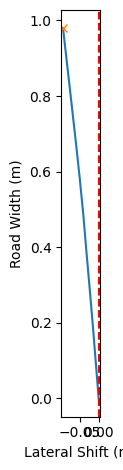

,recordingId,frame,uniqueTrackId,sceneId,roadWidth,sceneX,sceneY,sceneXVelocity,sceneYVelocity,sceneXAcceleration,sceneYAcceleration,speed,displacementX,displacementY,acceleration,localX,localY
0,18,750,18023,210,5.0,0.629400,2.454854,-0.047612,0.481508,-0.044860,-0.028943,0.483857,0.000000,0.000000,0.053387,-0.000000,-0.000000
1,18,752,18023,210,5.0,0.637141,2.358691,-0.038708,0.480816,-0.044520,0.003463,0.482371,0.007742,0.096163,0.044655,-0.007742,0.096163
2,18,754,18023,210,5.0,0.644921,2.261374,-0.038896,0.486585,0.000940,-0.028846,0.488137,0.015521,0.193480,0.028862,-0.015521,0.193480
3,18,756,18023,210,5.0,0.653314,2.163065,-0.041969,0.491544,0.015368,-0.024797,0.493333,0.023915,0.291789,0.029173,-0.023915,0.291789
4,18,758,18023,210,5.0,0.661952,2.065082,-0.043190,0.489915,0.006105,0.008146,0.491815,0.032553,0.389772,0.010180,-0.032553,0.389772
5,18,760,18023,210,5.0,0.670135,1.967831,-0.040911,0.486252,-0.011395,0.018314,0.487970,0.040735,0.487023,0.021570,-0.040735,0.487023
6,18,762,18023,210,5.0,0.679707,1.870670,-0.047861,0.485808,0.034750,0.002224,0.488159,0.050307,0.584184,0.034821,-0.050307,0.584184
7,18,764,18023,210,5.0,0.690215,1.773153,-0.052542,0.487584,0.023403,-0.008883,0.490407,0.060815,0.681701,0.025032,-0.060815,0.681701
8,18,766,18023,210,5.0,0.701232,1.674626,-0.055084,0.492634,0.012713,-0.025248,0.495704,0.071832,0.780228,0.028268,-0.071832,0.780228
9,18,768,18023,210,5.0,0.712428,1.575365,-0.055981,0.496305,0.004481,-0.018357,0.499452,0.083028,0.879489,0.018896,-0.083028,0.879489


In [13]:
starting023 = startingDf[startingDf["uniqueTrackId"] == 18023].copy()
visualizer.show(starting023, idCol = 'uniqueTrackId', xCol = 'localX', yCol = 'localY')
# starting023.size
starting023

In [22]:
angular023 = AngularDisplacementCalculator.addRelativeAngularDisplacement(starting023)
angular023

,recordingId,frame,uniqueTrackId,sceneId,roadWidth,sceneX,sceneY,sceneXVelocity,sceneYVelocity,sceneXAcceleration,sceneYAcceleration,speed,displacementX,displacementY,acceleration,localX,localY,relativeAngularDisplacement
0,18,750,18023,210,5.0,0.629400,2.454854,-0.047612,0.481508,-0.044860,-0.028943,0.483857,0.000000,0.000000,0.053387,-0.000000,-0.000000,0.000000
1,18,752,18023,210,5.0,0.637141,2.358691,-0.038708,0.480816,-0.044520,0.003463,0.482371,0.007742,0.096163,0.044655,-0.007742,0.096163,4.602626
2,18,754,18023,210,5.0,0.644921,2.261374,-0.038896,0.486585,0.000940,-0.028846,0.488137,0.015521,0.193480,0.028862,-0.015521,0.193480,-0.016269
3,18,756,18023,210,5.0,0.653314,2.163065,-0.041969,0.491544,0.015368,-0.024797,0.493333,0.023915,0.291789,0.029173,-0.023915,0.291789,0.099034
4,18,758,18023,210,5.0,0.661952,2.065082,-0.043190,0.489915,0.006105,0.008146,0.491815,0.032553,0.389772,0.010180,-0.032553,0.389772,0.088696
5,18,760,18023,210,5.0,0.670135,1.967831,-0.040911,0.486252,-0.011395,0.018314,0.487970,0.040735,0.487023,0.021570,-0.040735,0.487023,0.007028
6,18,762,18023,210,5.0,0.679707,1.870670,-0.047861,0.485808,0.034750,0.002224,0.488159,0.050307,0.584184,0.034821,-0.050307,0.584184,0.140766
7,18,764,18023,210,5.0,0.690215,1.773153,-0.052542,0.487584,0.023403,-0.008883,0.490407,0.060815,0.681701,0.025032,-0.060815,0.681701,0.176046
8,18,766,18023,210,5.0,0.701232,1.674626,-0.055084,0.492634,0.012713,-0.025248,0.495704,0.071832,0.780228,0.028268,-0.071832,0.780228,0.162220
9,18,768,18023,210,5.0,0.712428,1.575365,-0.055981,0.496305,0.004481,-0.018357,0.499452,0.083028,0.879489,0.018896,-0.083028,0.879489,0.132888


In [23]:
angularStartingDf = AngularDisplacementCalculator.addRelativeAngularDisplacement(startingDf)
angularStartingDf

,recordingId,frame,uniqueTrackId,sceneId,roadWidth,sceneX,sceneY,sceneXVelocity,sceneYVelocity,sceneXAcceleration,sceneYAcceleration,speed,displacementX,displacementY,acceleration,localX,localY,relativeAngularDisplacement
0,18,750,18023,210,5.0,0.629400,2.454854,-0.047612,0.481508,-0.044860,-0.028943,0.483857,0.000000,0.000000,0.053387,-0.000000,-0.000000,0.000000
1,18,752,18023,210,5.0,0.637141,2.358691,-0.038708,0.480816,-0.044520,0.003463,0.482371,0.007742,0.096163,0.044655,-0.007742,0.096163,4.602626
2,18,754,18023,210,5.0,0.644921,2.261374,-0.038896,0.486585,0.000940,-0.028846,0.488137,0.015521,0.193480,0.028862,-0.015521,0.193480,-0.016269
3,18,756,18023,210,5.0,0.653314,2.163065,-0.041969,0.491544,0.015368,-0.024797,0.493333,0.023915,0.291789,0.029173,-0.023915,0.291789,0.099034
4,18,758,18023,210,5.0,0.661952,2.065082,-0.043190,0.489915,0.006105,0.008146,0.491815,0.032553,0.389772,0.010180,-0.032553,0.389772,0.088696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25855,29,28036,29534,210,5.0,-0.178826,2.119379,-0.166191,0.636080,-0.052322,0.019468,0.657432,0.808226,0.335475,0.055826,-0.068569,0.255211,-0.392486
25856,29,28038,29534,210,5.0,-0.146855,1.991270,-0.159857,0.640545,-0.031668,-0.022326,0.660191,0.776255,0.463584,0.038747,-0.100541,0.383320,-0.341885
25857,29,28040,29534,210,5.0,-0.115425,1.860413,-0.157150,0.654283,-0.013535,-0.068690,0.672892,0.744825,0.594440,0.070011,-0.131971,0.514177,-0.301959
25858,29,28042,29534,210,5.0,-0.085571,1.726469,-0.149269,0.669719,-0.039406,-0.077177,0.686152,0.714971,0.728384,0.086655,-0.161825,0.648120,-0.375906


In [24]:
# max absolute value of angular displacement
maxAngularDisplacement = angularStartingDf["relativeAngularDisplacement"].abs().max()
# get the rows with max angular displacement
maxAngularDisplacementDf = angularStartingDf[angularStartingDf["relativeAngularDisplacement"].abs() == maxAngularDisplacement].copy()
maxAngularDisplacementDf

,recordingId,frame,uniqueTrackId,sceneId,roadWidth,sceneX,sceneY,sceneXVelocity,sceneYVelocity,sceneXAcceleration,sceneYAcceleration,speed,displacementX,displacementY,acceleration,localX,localY,relativeAngularDisplacement
6047,21,5335,21115,210,5.0,0.01941,2.363678,-0.284574,0.405198,-0.01963,-0.069678,0.495145,0.60999,0.091175,0.07239,-0.056915,0.08104,35.080712


In [25]:
# get the whole track of the pedestrian with max angular displacement
maxAngularDisplacementPedId = maxAngularDisplacementDf.iloc[0]["uniqueTrackId"]
maxAngularDisplacementPedDf = angularStartingDf[angularStartingDf["uniqueTrackId"] == maxAngularDisplacementPedId].copy()
maxAngularDisplacementPedDf

,recordingId,frame,uniqueTrackId,sceneId,roadWidth,sceneX,sceneY,sceneXVelocity,sceneYVelocity,sceneXAcceleration,sceneYAcceleration,speed,displacementX,displacementY,acceleration,localX,localY,relativeAngularDisplacement
6046,21,5333,21115,210,5.0,-0.037505,2.444718,-0.288500,0.391263,-0.039703,-0.064326,0.486126,0.666904,0.010136,0.075592,-0.000000,-0.000000,0.000000
6047,21,5335,21115,210,5.0,0.019410,2.363678,-0.284574,0.405198,-0.019630,-0.069678,0.495145,0.609990,0.091175,0.072390,-0.056915,0.081040,35.080712
6048,21,5337,21115,210,5.0,0.076074,2.280289,-0.283319,0.416948,-0.006276,-0.058747,0.504098,0.553326,0.174565,0.059082,-0.113579,0.164429,-0.446111
6049,21,5339,21115,210,5.0,0.132472,2.196568,-0.281990,0.418605,-0.006646,-0.008285,0.504726,0.496928,0.258286,0.010621,-0.169977,0.248150,-0.224420
6050,21,5341,21115,210,5.0,0.188448,2.113828,-0.279877,0.413699,-0.010566,0.024529,0.499478,0.440952,0.341026,0.026708,-0.225952,0.330890,-0.082508
6051,21,5343,21115,210,5.0,0.244117,2.031093,-0.278347,0.413676,-0.007648,0.000115,0.498603,0.385283,0.423761,0.007649,-0.281621,0.413625,-0.078224
6052,21,5345,21115,210,5.0,0.300305,1.947918,-0.280942,0.415872,0.012976,-0.010982,0.501875,0.329094,0.506935,0.017000,-0.337810,0.496800,-0.034831
6053,21,5347,21115,210,5.0,0.356761,1.863039,-0.282276,0.424395,0.006666,-0.042613,0.509697,0.272639,0.591814,0.043131,-0.394265,0.581679,-0.084971
6054,21,5349,21115,210,5.0,0.412551,1.776360,-0.278953,0.433397,-0.016612,-0.045010,0.515410,0.216849,0.678494,0.047977,-0.450056,0.668358,-0.174294
6055,21,5351,21115,210,5.0,0.467240,1.687514,-0.273446,0.444229,-0.027537,-0.054162,0.521644,0.162159,0.767340,0.060760,-0.504745,0.757204,-0.268302


In [27]:
def findMaxAngularDisplacementPedDf(df):
    angularDf = AngularDisplacementCalculator.addRelativeAngularDisplacement(df)
    # ommit the 2nd row of every track
    for pedId in angularDf["uniqueTrackId"].unique():
        angularDf = angularDf.drop(angularDf[angularDf["uniqueTrackId"] == pedId].iloc[1].name)
    # get the max angular displacement
    maxAngularDisplacement = angularDf["relativeAngularDisplacement"].abs().max()
    # get the rows with max angular displacement
    maxAngularDisplacementDf = angularDf[angularDf["relativeAngularDisplacement"].abs() == maxAngularDisplacement].copy()
    return maxAngularDisplacementDf

findMaxAngularDisplacementPedDf(cleanPedDf)



,recordingId,frame,uniqueTrackId,sceneId,roadWidth,sceneX,sceneY,sceneXVelocity,sceneYVelocity,sceneXAcceleration,sceneYAcceleration,speed,displacementX,displacementY,acceleration,localX,localY,relativeAngularDisplacement
19584,27,17135,27304,210,5.0,-0.007707,1.716572,-0.01607,0.575113,-0.190632,-0.155814,0.575337,0.637107,0.738281,0.246208,-0.204846,0.761989,-2.262937


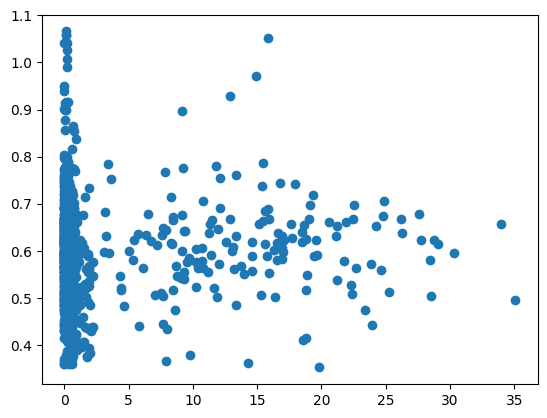

In [28]:
# plot a graph between absolute angular displacement and speed at each datapoint
# get the absolute angular displacement
# angularStartingDf["absAngularDisplacement"] = angularStartingDf["relativeAngularDisplacement"].abs()
# plot the graph
plt.scatter(angularStartingDf["relativeAngularDisplacement"].abs(), angularStartingDf["speed"])